In [1]:
#| include: false
!pip install -Uqq fastcore albumentations tqdm

     |████████████████████████████████| 56 kB 2.3 MB/s eta 0:00:011
     |████████████████████████████████| 98 kB 4.6 MB/s 
     |████████████████████████████████| 76 kB 4.1 MB/s 
     |████████████████████████████████| 37.1 MB 49 kB/s 


In [2]:
#| include: false
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    if title is not None: 
      ax.set_title(title)

    return ax

# Imports

In [4]:
#| code-fold: true
#| code-summary: "Imports"
import os
import urllib
import urllib.request
import shutil
from glob import glob
import cv2
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

# PyTorch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
import torch.backends.cudnn as cudnn

# Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# fasctore
from fastcore.all import *

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

cudnn.benchmark = True

# Introduction

In 2015, Kaiming He and other researchers form Microsoft introduced a novel training approach that won them the ILSVRC competition. Their approach was based on residual learning that eased the training of substantially deeper networks, which was unheard of at that time. Resnets, as they are commonly referred to now, have been very influential in that modern networks usually build on the concept introduced by them.

In this blog post, we are going to be implementing their research paper and trying to get an intuition of what the residual learning framework means. I also try to run the experiments they ran (although in a smaller scale) and see if we land the same results as them.

The research paper can be found here: https://arxiv.org/pdf/1512.03385.pdf

## Getting the Data

For our experiments, we are going to be using the [Imagenette Dataset](https://github.com/fastai/imagenette), created by [Jeremy Howard](https://twitter.com/jeremyphoward/status/1103129618435923968?lang=en), which is a subset of the Imagenet Dataset, but with only 10 classes and fewer images than the original.

In [5]:
URL = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz'
FILE = 'imagenette2-320.tgz'
FOLDER = 'data'

We create a small function that fetches the data and returns a Path object poining to where the data is:

In [6]:
def get_data(URL, FILE, FOLDER):
  # This is a function that downloads and extracts the data
  # then returns a pathlib object containing the location of the data

  # Downloading
  if not os.path.isfile(FILE):
    print(f'Downloading {URL} and saving it as {FILE}')
    print('-'*120)
    urllib.request.urlretrieve(URL, FILE)
    print('Finished Downloading')
  else:
    print(f'{FILE} already exists')
  
  # Extracting
  print('\n')
  print(f'Extracting Files into {FOLDER}')
  shutil.unpack_archive(FILE, FOLDER)
  return Path(FOLDER)

In [7]:
path = get_data(URL, FILE, FOLDER)

------------------------------------------------------------------------------------------------------------------------
Finished Downloading


Extracting Files into data


In [8]:
#| include: false
Path.BASE_PATH = path

We are using the slightly modified Path object from `fastcore` which has useful functions, like `ls` which prints the files and folders present in our path. You can learn more about [fastcore here](https://fastcore.fast.ai/) and its functionalities.

In [9]:
(path/'imagenette2-320').ls()

(#3) [Path('imagenette2-320/val'),Path('imagenette2-320/train'),Path('imagenette2-320/noisy_imagenette.csv')]

We can look inside the training folder to see what we are working with:

In [10]:
(path/'imagenette2-320'/'train').ls()

(#10) [Path('imagenette2-320/train/n03888257'),Path('imagenette2-320/train/n02102040'),Path('imagenette2-320/train/n03028079'),Path('imagenette2-320/train/n03000684'),Path('imagenette2-320/train/n02979186'),Path('imagenette2-320/train/n03394916'),Path('imagenette2-320/train/n03425413'),Path('imagenette2-320/train/n03417042'),Path('imagenette2-320/train/n01440764'),Path('imagenette2-320/train/n03445777')]

Now, we will recursively go through all the folders and create a list of all `JPEG` files:

In [11]:
files = L(glob(f'{path}/**/*.JPEG', recursive=True)).map(Path)
files[0]

Path('imagenette2-320/val/n03888257/n03888257_19462.JPEG')

In [12]:
len(files)

13394

We can see that we have around 13,000 images to work with, which is reasonable for our task at hand.

Another useful item that we are going to require for modelling purposes is the labels of all the images. Our images have been arranged folder-wise, where each folder represent a different class:

In [13]:
lbls = files.map(Self.parent.name()).unique()
lbls

(#10) ['n03888257','n02102040','n03028079','n03000684','n02979186','n03394916','n03425413','n03417042','n01440764','n03445777']

Our Neural Network expects numerical input so we need to convert those labels to numbers:

In [14]:
v2i = lbls.val2idx()
v2i

{'n01440764': 8,
 'n02102040': 1,
 'n02979186': 4,
 'n03000684': 3,
 'n03028079': 2,
 'n03394916': 5,
 'n03417042': 7,
 'n03425413': 6,
 'n03445777': 9,
 'n03888257': 0}

Now we can create our Dataset, specify some transforms we need, split the data into training and validation and create a function that returns our Dataloaders:

In [15]:
class Imagenette(Dataset):
  def __init__(self, files, v2i, transform=None):
    self.files = files
    self.v2i = v2i
    self.transform = transform
  
  def __len__(self):
    return len(self.files)
  
  def __getitem__(self, idx):
    image_filepath = self.files[idx]
    image = cv2.imread(f'{image_filepath}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = self.v2i[self.files[idx].parent.name]

    # transform if available
    if self.transform is not None:
      image = self.transform(image=image)["image"]
    
    return image, label

In [16]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [17]:
train_filt = L(o.parent.parent.name=='train' for o in files)
train,valid = files[train_filt],files[~train_filt]
len(train),len(valid)

(9469, 3925)

In [18]:
train_ds = Imagenette(train, v2i, train_transform)
valid_ds = Imagenette(valid, v2i, val_transform)
x,y = train_ds[1000]
x.shape,y

(torch.Size([3, 128, 128]), 1)

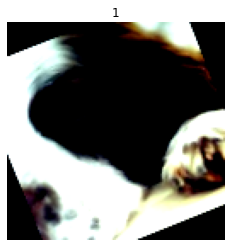

In [19]:
imshow(x, title=y);

In [20]:
def get_dls(bs):
  train_dl = DataLoader(
    train_ds, 
    batch_size=bs,
    shuffle=True,
    num_workers=2,
    pin_memory=True)

  val_dl = DataLoader(
    valid_ds, 
    batch_size=bs, 
    shuffle=False,
    num_workers=2,
    pin_memory=True)
  
  return train_dl, val_dl

We can now explore the paper since we have data preparation out of our way.

# ResNets

## Base Vanilla Model

We are going to start with a small base model, which will just be a vanilla model of Conv Layers stacked onto each other.

We specify a function that takes in number of inputs, number of features, kernel size and the stride and returns a sequence of a Conv Layer, a BatchNorm Layer and finally the activation layer, which is going to be Relu. This is a typical sequence in Deep Learning.

In [21]:
def ConvLayer(ni, nf, ks, stride):
  layers = nn.Sequential(
      nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False),
      nn.BatchNorm2d(nf),
      nn.ReLU())
  return layers

And now define what a block will look like in our model. Note we go for a default kernel of size 3 and stride 2.

In [22]:
def block(ni, nf, ks=3, stride=2):
  return ConvLayer(ni, nf, ks, stride)

We now create our Small Network that will serve as our Base Model. It is a bunch of Conv Layers followed by a Global Average Pool and finally a Linear Classifier that outputs 10 activations:

In [23]:
class SmallNetwork(nn.Module):
  def __init__(self):
    super(SmallNetwork, self).__init__()
    self.convs = nn.Sequential(
        block(3, 16, ks=5),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256))
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.linear = nn.Linear(256, len(v2i))
  
  def forward(self, x):
    out = self.convs(x)
    out = self.pool(out)
    out = nn.Flatten()(out)
    out = self.linear(out)

    return out

In [24]:
#| code-fold: true
def calculate_accuracy(preds, target):
  correct = 0
  total = 0

  predicted = torch.argmax(preds, axis=1)
  total += target.shape[0]
  correct += int((predicted==target).sum())

  return correct / total

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

def init_weights(m):
  if type(m) == nn.Linear or type(m) == nn.Conv2d:
    nn.init.xavier_uniform_(m.weight)

We define our training and validation loops:

In [25]:
def train(train_loader, model, criterion, optimizer, epoch, scheduler=None):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_dl)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler:
          scheduler.step()
        stream.set_description(
            "Epoch: {epoch}. Train       {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [26]:
def validate(val_loader, model, criterion, epoch):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(valid_dl)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation  {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

We use a batch size of 64 for our experiments, and train our network for 10 epoch using a learning rate of 0.003

In [27]:
train_dl, valid_dl = get_dls(64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
num_epochs=10
lr = 3e-3

sm_model = SmallNetwork()
sm_model = sm_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(sm_model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                          steps_per_epoch=int(len(train_dl)),
                                          epochs=num_epochs,
                                          anneal_strategy='linear')

sm_model.apply(init_weights);

In [29]:
for epoch in range(1, num_epochs + 1):
  train(train_dl, sm_model, criterion, optimizer, epoch, scheduler)
  validate(valid_dl, sm_model, criterion, epoch)
  print()

Epoch: 1. Train       Loss: 1.925 | Accuracy: 0.328: 100%|██████████| 148/148 [00:30<00:00,  4.80it/s]
Epoch: 1. Validation  Loss: 1.771 | Accuracy: 0.394: 100%|██████████| 62/62 [00:10<00:00,  6.02it/s]


Epoch: 2. Train       Loss: 1.725 | Accuracy: 0.409: 100%|██████████| 148/148 [00:29<00:00,  4.94it/s]
Epoch: 2. Validation  Loss: 1.639 | Accuracy: 0.473: 100%|██████████| 62/62 [00:10<00:00,  6.09it/s]


Epoch: 3. Train       Loss: 1.641 | Accuracy: 0.441: 100%|██████████| 148/148 [00:30<00:00,  4.91it/s]
Epoch: 3. Validation  Loss: 1.589 | Accuracy: 0.496: 100%|██████████| 62/62 [00:10<00:00,  6.11it/s]


Epoch: 4. Train       Loss: 1.534 | Accuracy: 0.487: 100%|██████████| 148/148 [00:30<00:00,  4.88it/s]
Epoch: 4. Validation  Loss: 1.278 | Accuracy: 0.587: 100%|██████████| 62/62 [00:10<00:00,  6.10it/s]


Epoch: 5. Train       Loss: 1.428 | Accuracy: 0.526: 100%|██████████| 148/148 [00:30<00:00,  4.92it/s]
Epoch: 5. Validation  Loss: 1.295 | Accuracy: 0.582: 100%|██████████| 62/62 [00:10<00:00,  6.07it/s]


Epoch: 6. Train       Loss: 1.325 | Accuracy: 0.562: 100%|██████████| 148/148 [00:29<00:00,  4.96it/s]
Epoch: 6. Validation  Loss: 1.487 | Accuracy: 0.547: 100%|██████████| 62/62 [00:10<00:00,  6.12it/s]


Epoch: 7. Train       Loss: 1.244 | Accuracy: 0.592: 100%|██████████| 148/148 [00:30<00:00,  4.91it/s]
Epoch: 7. Validation  Loss: 1.118 | Accuracy: 0.642: 100%|██████████| 62/62 [00:10<00:00,  6.04it/s]


Epoch: 8. Train       Loss: 1.185 | Accuracy: 0.611: 100%|██████████| 148/148 [00:30<00:00,  4.90it/s]
Epoch: 8. Validation  Loss: 1.056 | Accuracy: 0.661: 100%|██████████| 62/62 [00:10<00:00,  6.07it/s]


Epoch: 9. Train       Loss: 1.114 | Accuracy: 0.634: 100%|██████████| 148/148 [00:30<00:00,  4.87it/s]
Epoch: 9. Validation  Loss: 0.968 | Accuracy: 0.694: 100%|██████████| 62/62 [00:10<00:00,  6.02it/s]


Epoch: 10. Train       Loss: 1.066 | Accuracy: 0.657: 100%|██████████| 148/148 [00:30<00:00,  4.89it/s]
Epoch: 10. Validation  Loss: 0.895 | Accuracy: 0.714: 100%|██████████| 62/62 [00:10<00:00,  6.05it/s]

After the 10 epochs, we get a Training Loss of about 1.09 and a Validation Loss of 0.89 which yields an Accuracy of about 72%.

Now we can start performing the experiments from the paper.

## Is Learning Better Networks as easy as stacking more layers?

This was a question the researchers were very interested in, in their paper. Evidence had revealved that network depth was of crucual importance as the previous leading results on the Imagenet Challenge all exploited "very deep networks". Driven by this understanding, a natural question arose, *Is learning better networks as easy as stacking more layers?*

Quoting their paper
> When deeper networks are able to start converging, a *degradation* problem has been exposed: with the network depth increasing, accuracy gets saturated and then degrades rapidly. Unexpectedly, such degradation is *not caused by overfitting*, and adding more layers to a suitably deep model leads to *higher training error* as shown below.

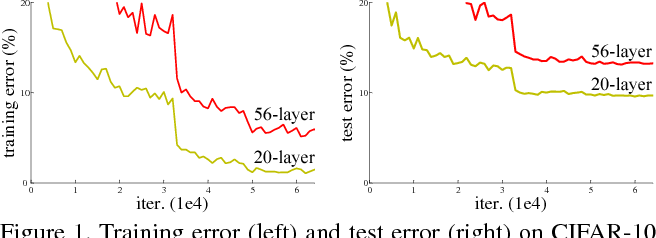

Let us try and understand that paragraph. The researchers were wondering whether stacking more layers onto each other which yields deeper networks gave better models. Past evidence has already shown how important deep models could be, but was deep models as easy as just stacking more layers?

To investigate that phenomenal, the researchers perfomed an experiment using two networks. One with 20 layers and one substantially deeper with 56 layers. Surprisingly, the 20-layer network achieved both a lower training error and test error. This means that the 20-layer network was better than the 56-layer network. Hence, the deeper network experienced what the researchers called degredation.

Furthermore, the degradation wasn't caused by overfitting the training data. If this was the case, we would observe the deeper network having a lower training error than the shallow one, then having a higher test error than the shallow one since it would have memorized the data instead of learning from it (as deeper models often do).

But in their experiments, they observed that the shallower network had both lower training and test errors. This meant that the deeper counterparts weren't really learning the data.

The degradation observed here implies that not all systems are similary easy to optimize.

Let us experimentally try to see the degradation problem for ourself. To do this, we will modify our `block` function to return 3 Conv Layers instead of one, that way, we will end up with a model that is 3 times deeper than our base model:

In [30]:
def block(ni, nf, ks=3, stride=2):
  return nn.Sequential(
      ConvLayer(ni, nf, ks, stride),
      ConvLayer(nf, nf, ks, stride),
      ConvLayer(nf, nf, ks, stride)
  )

In [31]:
class LargerNetwork(nn.Module):
  def __init__(self):
    super(LargerNetwork, self).__init__()
    self.convs = nn.Sequential(
        block(3, 16, ks=5),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256))
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.linear = nn.Linear(256, len(v2i))
  
  def forward(self, x):
    out = self.convs(x)
    out = self.pool(out)
    out = nn.Flatten()(out)
    out = self.linear(out)

    return out

We train the model for the same amount of epochs using the same hyperparameters:

In [32]:
num_epochs=10
lr = 3e-3

lg_model = LargerNetwork()
lg_model = lg_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lg_model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                          steps_per_epoch=int(len(train_dl)),
                                          epochs=num_epochs,
                                          anneal_strategy='linear')

lg_model.apply(init_weights);

In [33]:
for epoch in range(1, num_epochs + 1):
  train(train_dl, lg_model, criterion, optimizer, epoch, scheduler)
  validate(valid_dl, lg_model, criterion, epoch)
  print()

Epoch: 1. Train       Loss: 2.347 | Accuracy: 0.149: 100%|██████████| 148/148 [00:31<00:00,  4.69it/s]
Epoch: 1. Validation  Loss: 2.159 | Accuracy: 0.195: 100%|██████████| 62/62 [00:10<00:00,  6.04it/s]


Epoch: 2. Train       Loss: 2.130 | Accuracy: 0.225: 100%|██████████| 148/148 [00:31<00:00,  4.76it/s]
Epoch: 2. Validation  Loss: 2.056 | Accuracy: 0.275: 100%|██████████| 62/62 [00:10<00:00,  5.96it/s]


Epoch: 3. Train       Loss: 2.065 | Accuracy: 0.263: 100%|██████████| 148/148 [00:31<00:00,  4.74it/s]
Epoch: 3. Validation  Loss: 2.079 | Accuracy: 0.255: 100%|██████████| 62/62 [00:10<00:00,  6.09it/s]


Epoch: 4. Train       Loss: 2.001 | Accuracy: 0.297: 100%|██████████| 148/148 [00:31<00:00,  4.76it/s]
Epoch: 4. Validation  Loss: 1.917 | Accuracy: 0.334: 100%|██████████| 62/62 [00:10<00:00,  6.01it/s]


Epoch: 5. Train       Loss: 1.940 | Accuracy: 0.319: 100%|██████████| 148/148 [00:30<00:00,  4.79it/s]
Epoch: 5. Validation  Loss: 1.865 | Accuracy: 0.355: 100%|██████████| 62/62 [00:10<00:00,  6.05it/s]


Epoch: 6. Train       Loss: 1.877 | Accuracy: 0.350: 100%|██████████| 148/148 [00:31<00:00,  4.77it/s]
Epoch: 6. Validation  Loss: 1.896 | Accuracy: 0.352: 100%|██████████| 62/62 [00:10<00:00,  6.02it/s]


Epoch: 7. Train       Loss: 1.833 | Accuracy: 0.360: 100%|██████████| 148/148 [00:30<00:00,  4.80it/s]
Epoch: 7. Validation  Loss: 1.629 | Accuracy: 0.433: 100%|██████████| 62/62 [00:10<00:00,  6.07it/s]


Epoch: 8. Train       Loss: 1.768 | Accuracy: 0.391: 100%|██████████| 148/148 [00:30<00:00,  4.78it/s]
Epoch: 8. Validation  Loss: 1.618 | Accuracy: 0.451: 100%|██████████| 62/62 [00:10<00:00,  6.01it/s]


Epoch: 9. Train       Loss: 1.711 | Accuracy: 0.408: 100%|██████████| 148/148 [00:31<00:00,  4.73it/s]
Epoch: 9. Validation  Loss: 1.559 | Accuracy: 0.479: 100%|██████████| 62/62 [00:10<00:00,  5.97it/s]


Epoch: 10. Train       Loss: 1.683 | Accuracy: 0.418: 100%|██████████| 148/148 [00:31<00:00,  4.66it/s]
Epoch: 10. Validation  Loss: 1.562 | Accuracy: 0.471: 100%|██████████| 62/62 [00:10<00:00,  5.95it/s]

After the 10 epochs, we prove what the paper was claiming. Stacking Layers onto each other doesn't work. Adding more layers to a suitably deep model leads to a *higher training error* and a *higher test error*.

Therefore, the question then becomes, what then constitues of a better model if just plainly stacking layers won't work?

## What about Identity Mappings?

The researchers went on and investigated

> Let us consider a shallower architecture and its deeper counterpart that adds more layers onto it. There exists a solution by construction to the deeper model: the added layers are *identity mappings*, and the other layers are copied from the learned shallower model. The existence of this constructed solution indicates that a deeper model should produce no higher training error than its shallower counterpart.

To put that in more English like language, here is what they mean: Train a shallow model first, say 20 layers. Then after, make this shallow model deeper by adding more layers onto it, say 30 layers. The only catch is, the layers that are added have to be Identity mappings, which simply means they do nothing. They simply get an input and output the same input. So they just sort of pass the input around. 

Think about this new form of deeper model. The model is now 50 layers deep, but the first 20 layers are similar to our shallow model, and the added 30 layers do absolutely nothing to the inputs they recieve. Therefore, our 50 layer model should produce the exact same training and test errors as the 20 layer model.

Let us see that in code.

PyTorch provides us with an Identity Layer that works as follows, the output is exactly the same as the input provided.

In [34]:
x = torch.randn(1, 3, 64, 64)
m = nn.Identity()
m(x).shape

torch.Size([1, 3, 64, 64])

Now we create a function that returns 30 of this Identity Layers.

In [35]:
def identity_layers():
  layers = []
  for _ in range(30):
    layers.append(nn.Identity())

  return nn.Sequential(*layers).to(device)

And now we append them to the Base Model we had trained earlier and validate it on our data.

In [36]:
model_identity = nn.Sequential(
    sm_model,
    identity_layers()
)

In [37]:
validate(valid_dl, model_identity, criterion, 1)

Epoch: 1. Validation  Loss: 0.895 | Accuracy: 0.714: 100%|██████████| 62/62 [00:10<00:00,  5.95it/s]


We get the same validation loss and accuracy as our base model since the Identity Layers don't do anything, proving that there are always deep networks that should be at least as good as any shallow network. But for some reason, SGD does not seem able to find them (or unable to do so in feasible time). This again proves that not all systems are easy to optimize.

## Residual Learning

Since stacking layers didn't work, although theoretically they should, the researchers proposed to address the degradation problem of deep networks using a *deep residual learning framework*.

> Instead of hoping each few stacked layers directly fit a desired underlying mapping, we explicitely let these layers fit a residual mapping.

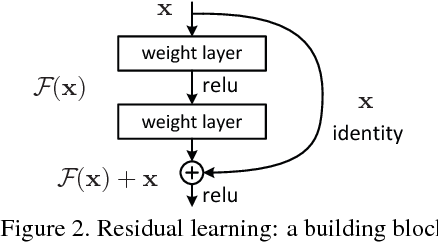

Again, let us try explaining that in an understandable manner. Above is the Residual Block that the researchers proposed.

Assume that the output of this block (after the relu) is supposed to be $$y$$ and the residual block (the sequence of weight layers) learns the function $$F(x)$$

We see that the input is added just before the relu, so the whole equation becomes: $$y = F(x) + x$$

This function can be written in another format, making `F(x)` the subject of the formula: $$F(x) = y - x$$ which is the residual mapping that the weight layers learn.

In other words, If the outcome of a given layer is supposed to be `y`, we're not asking the block to predict `y`, we are asking it to predict the difference between the desired outcome, `y` and the input `x`. Or in short, what should the layer do its input `x` to make it like the desired output `y`.

The job of the layer now isn't to predict certain features, but to minimize the error between `x` and the desired `y`. This proves to be an easier task, that asking our block to just predict a desired outcome `y` out of nowhere. This is achievied using skip connections (how the input is added after passing through the weight layers just before the activation - or in other terms, how it skips throught the connection).

> Intuition: This is my intuition of the Residual Learning Framework. Giving the layer something to work with makes it easier for it to learn. Imagine walking into a barber shop or a salon. Now imagine telling the attendant to give you a haircut and it must be meaningful. Hypothetically, the attendant can give you a meaningful haircut (it is possible) but it will be hard to do that out of nowhere (it might not be that feasible). Imagine instead if you came in with a picture of what you want and gave it to him or her. Now it will be easier for the barber or hair salon to make your hair (the input `x`) similar to the picture (the output `y`). Or in other words, the attendant will now find it easier to minimize the error between the input and the desired output.

Let us see this in code format, which is always easier.

We change our definition of ConvLayer to accomodate the skip connection. Now our layer will return two different things depending on whether the layer is a normal weight layer (the first weight layer in the picture above) which includes a Convolution, followed by a BatchNorm then Relu or an identity layer (the second weight layer without an activation function) which consists of a Convolution, followed by BatchNorm, whose `gamma` value is initialized to zero. Recall that a BatcNorm layer does `gamma*x + beta`. Therefore, passing through this second layer won't do anything because `x + conv(x)` will just result in `x`, acting as an identity mapping.

In [38]:
def ConvLayer(ni, nf, ks, stride, identity=False):
  layers = []
  layers.append(nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, 
                          bias=False))
  norm = nn.BatchNorm2d(nf)
  # if identity conv block, init gamma to zero and no activation
  if identity == True:
    nn.init.zeros_(norm.weight)
    layers.append(norm)
    return nn.Sequential(*layers)
  # normal conv block
  else:
    layers.append(norm)
    layers.append(nn.ReLU())
    return nn.Sequential(*layers)

We can test out a few setups for intuiton. First, we return a normal ConvLayer (not an identity):

In [39]:
ConvLayer(3, 32, 3, 2, identity=False)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

And then an identity ConvLayer:

In [40]:
ConvLayer(3, 32, 3, 2, identity=True)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Now, according to the image above, a ResNet Block will always consist of a normal weight layer followed by an identity weight layer so we can create a function that return that block of code:

In [41]:
def _conv_block(ni, nf, ks, stride):
  return nn.Sequential(
      ConvLayer(ni, nf, ks, stride),
      ConvLayer(nf, nf, ks, stride=1, identity=True)
  )

Again, we can test it out to get an intuition of how it works:

In [42]:
_conv_block(3, 32, 3, 2)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [43]:
#| code-fold: true
def noop(x=None):
  return x

Finally, we can create the logic of the ResNet block of code. The forward loop will be equal to `x + _conv_block(x)` then passed through the ReLU, just like the picture we had above

But we should also handle for two cases that may arise:

1. If the number of inputs (ni) is different from the number of features or channels outputted (nf), we are going to have a problem during the adding because the input, x and the output of the _conv_block will have different shapes. Therefore, we will need to change the channels of the inputs using a 1x1 Convolution which we will call `idconv`. To learn more about 1x1 Convolutions and how they can be used to change the number of channels, [read this](https://machinelearningmastery.com/introduction-to-1x1-convolutions-to-reduce-the-complexity-of-convolutional-neural-networks/).

2. If we use a stride greater than 1 on the convolutions, their output maps are going to be halved, again resulting in a different shape than the input, therefore they cannot be added together. Therefore, we will need to reduce the feature map of the input too using and Average Pool with stride 2.

Note, `noop` here means no operation, meaning nothing is done on the input if ni==nf and the stide==1, otherwise, the above situations are handled appropriately.

In [44]:
class ResBlock(nn.Module):
  def __init__(self, ni, nf, ks=3, stride=2):
    super().__init__()
    self.convs = _conv_block(ni, nf, ks, stride)
    self.idconv = noop if ni==nf else nn.Conv2d(ni, nf, kernel_size=1)
    self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
  
  def forward(self, x):
    return F.relu(self.convs(x) + self.idconv(self.pool(x)))

We will now modify the block function we used to create the large model, and let it return Residual Blocks instead of just stacking ordinary layers on top of each other.

In [45]:
def block(ni, nf, ks=3, stride=2):
  return nn.Sequential(
      ResBlock(ni, nf, ks, stride),
      ResBlock(nf, nf, ks, stride),
      ResBlock(nf, nf, ks, stride)
  )

We then define a Network that is as deep as our LargerNetwork, but with residual blocks instead. Other than that, our ResidualNetwork is as deep as our previous model that performed poorly. That way, we can compare both of them and see the direct benefit of using what the researchers called the *deep residual learning framework*.

In [46]:
class ResidualNetwork(nn.Module):
  def __init__(self):
    super(ResidualNetwork, self).__init__()
    self.convs = nn.Sequential(
        block(3, 16, ks=5),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256))
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.linear = nn.Linear(256, len(v2i))
  
  def forward(self, x):
    out = self.convs(x)
    out = self.pool(out)
    out = nn.Flatten()(out)
    out = self.linear(out)

    return out

Again, we train for the same number of epochs using the same hyperparameters:

In [47]:
num_epochs=10
lr = 3e-3

rs_model = ResidualNetwork()
rs_model = rs_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rs_model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                          steps_per_epoch=int(len(train_dl)),
                                          epochs=num_epochs,
                                          anneal_strategy='linear')

rs_model.apply(init_weights);

In [48]:
for epoch in range(1, num_epochs + 1):
  train(train_dl, rs_model, criterion, optimizer, epoch, scheduler)
  validate(valid_dl, rs_model, criterion, epoch)
  print()

Epoch: 1. Train       Loss: 2.104 | Accuracy: 0.252: 100%|██████████| 148/148 [00:34<00:00,  4.25it/s]
Epoch: 1. Validation  Loss: 1.946 | Accuracy: 0.316: 100%|██████████| 62/62 [00:10<00:00,  5.80it/s]


Epoch: 2. Train       Loss: 1.905 | Accuracy: 0.329: 100%|██████████| 148/148 [00:33<00:00,  4.37it/s]
Epoch: 2. Validation  Loss: 1.754 | Accuracy: 0.382: 100%|██████████| 62/62 [00:10<00:00,  5.92it/s]


Epoch: 3. Train       Loss: 1.842 | Accuracy: 0.357: 100%|██████████| 148/148 [00:33<00:00,  4.46it/s]
Epoch: 3. Validation  Loss: 1.865 | Accuracy: 0.378: 100%|██████████| 62/62 [00:10<00:00,  5.92it/s]


Epoch: 4. Train       Loss: 1.749 | Accuracy: 0.396: 100%|██████████| 148/148 [00:33<00:00,  4.44it/s]
Epoch: 4. Validation  Loss: 1.535 | Accuracy: 0.474: 100%|██████████| 62/62 [00:10<00:00,  5.90it/s]


Epoch: 5. Train       Loss: 1.652 | Accuracy: 0.436: 100%|██████████| 148/148 [00:32<00:00,  4.49it/s]
Epoch: 5. Validation  Loss: 1.444 | Accuracy: 0.519: 100%|██████████| 62/62 [00:10<00:00,  5.90it/s]


Epoch: 6. Train       Loss: 1.546 | Accuracy: 0.472: 100%|██████████| 148/148 [00:33<00:00,  4.43it/s]
Epoch: 6. Validation  Loss: 1.436 | Accuracy: 0.525: 100%|██████████| 62/62 [00:10<00:00,  5.85it/s]


Epoch: 7. Train       Loss: 1.486 | Accuracy: 0.494: 100%|██████████| 148/148 [00:33<00:00,  4.37it/s]
Epoch: 7. Validation  Loss: 1.403 | Accuracy: 0.547: 100%|██████████| 62/62 [00:10<00:00,  5.78it/s]


Epoch: 8. Train       Loss: 1.408 | Accuracy: 0.528: 100%|██████████| 148/148 [00:34<00:00,  4.35it/s]
Epoch: 8. Validation  Loss: 1.245 | Accuracy: 0.584: 100%|██████████| 62/62 [00:10<00:00,  5.83it/s]


Epoch: 9. Train       Loss: 1.350 | Accuracy: 0.546: 100%|██████████| 148/148 [00:34<00:00,  4.34it/s]
Epoch: 9. Validation  Loss: 1.162 | Accuracy: 0.619: 100%|██████████| 62/62 [00:10<00:00,  5.82it/s]


Epoch: 10. Train       Loss: 1.301 | Accuracy: 0.562: 100%|██████████| 148/148 [00:34<00:00,  4.33it/s]
Epoch: 10. Validation  Loss: 1.114 | Accuracy: 0.640: 100%|██████████| 62/62 [00:10<00:00,  5.69it/s]

We get a really good result just by switching normal stacked Conv Layers with Residual Layers. Recall that this new network is just as deep as the Big Model we created earlier! The Residual Learning framework does really work.

## Resnet 18

Our model earlier wasn't designed that well (although it worked regardless). We just stacked Residual Layers ontop of each other without consideration of other factors.

Luckily for us, the authors of the paper came up with a number of designs that they named depending on how many layers the network hard. You can see the configurations in the picture below:

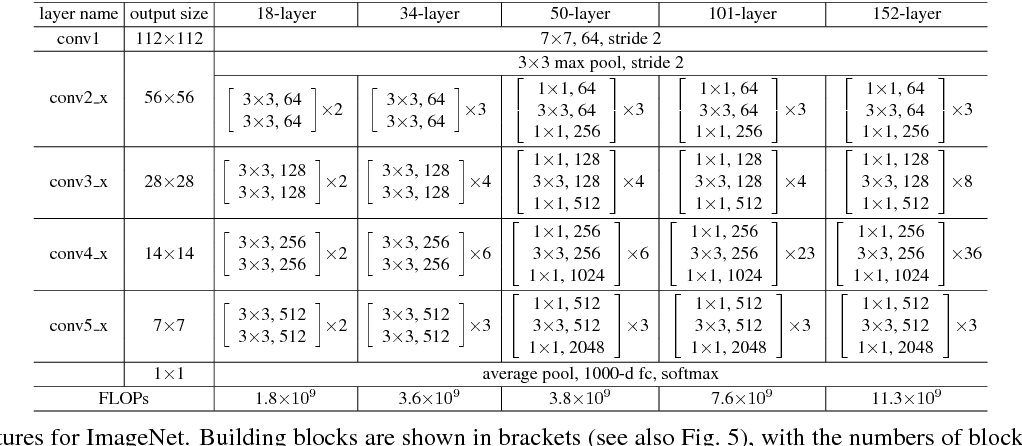

For our simple use case, we can use the 18-layer Residual Network, or as it is commonly known, the `Resnet-18`. 

Note that most frameworks provide these models readily, whether you need a pre-trained one for fine-tuning or you need just the structure and you train it for yourself. For example, the resnet-18 by PyTorch can be found [here](https://pytorch.org/hub/pytorch_vision_resnet/).

But since we are learning, why not implement the model ourselves? It will make for a good challenge.

Here is my from-scratch implementation of the network as per my understanding and using the image above. You might want to pause here for a second and try and understand what I did. It is pretty self explanatory though.

In [53]:
class Resnet18(nn.Module):
  def __init__(self):
    super(Resnet18, self).__init__()
    self.convs = nn.Sequential(
        ConvLayer(3, 64, ks=7, stride=2),
        nn.MaxPool2d(kernel_size=3, stride=2),
        ResBlock(64, 64, stride=1),
        ResBlock(64, 64, stride=1),
        ResBlock(64, 128),
        ResBlock(128, 128, stride=1),
        ResBlock(128, 256),
        ResBlock(256, 256, stride=1),
        ResBlock(256, 512),
        ResBlock(512, 512, stride=1))
    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.linear = nn.Linear(512, 10)
  
  def forward(self, x):
    out = self.convs(x)
    out = self.avgpool(out)
    out = nn.Flatten()(out)
    out = self.linear(out)
    return out

We can instantiate our Module and see if its layers match the Resnet-18 layer structure by the researchers:

In [50]:
resnet18 = Resnet18()
resnet18

Resnet18(
  (convs): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (convs): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (3): ResBlock(
      (convs): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

Again, we train the model using the same hyperparameters and for the same number of epochs, for comparisons sake.

In [51]:
num_epochs=10
lr = 3e-3

resnet18 = Resnet18()
resnet18 = resnet18.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                          steps_per_epoch=int(len(train_dl)),
                                          epochs=num_epochs,
                                          anneal_strategy='linear')

resnet18.apply(init_weights);

In [52]:
for epoch in range(1, num_epochs+1):
  train(train_dl, resnet18, criterion, optimizer, epoch, scheduler)
  validate(valid_dl, resnet18, criterion, epoch)
  print()

  0%|          | 0/148 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch: 1. Train       Loss: 1.977 | Accuracy: 0.303: 100%|██████████| 148/148 [00:37<00:00,  3.95it/s]
Epoch: 1. Validation  Loss: 1.840 | Accuracy: 0.337: 100%|██████████| 62/62 [00:11<00:00,  5.39it/s]


Epoch: 2. Train       Loss: 1.709 | Accuracy: 0.418: 100%|██████████| 148/148 [00:35<00:00,  4.16it/s]
Epoch: 2. Validation  Loss: 1.491 | Accuracy: 0.504: 100%|██████████| 62/62 [00:11<00:00,  5.44it/s]


Epoch: 3. Train       Loss: 1.626 | Accuracy: 0.446: 100%|██████████| 148/148 [00:36<00:00,  4.10it/s]
Epoch: 3. Validation  Loss: 1.404 | Accuracy: 0.541: 100%|██████████| 62/62 [00:11<00:00,  5.47it/s]


Epoch: 4. Train       Loss: 1.476 | Accuracy: 0.507: 100%|██████████| 148/148 [00:35<00:00,  4.17it/s]
Epoch: 4. Validation  Loss: 1.229 | Accuracy: 0.597: 100%|██████████| 62/62 [00:11<00:00,  5.48it/s]


Epoch: 5. Train       Loss: 1.333 | Accuracy: 0.559: 100%|██████████| 148/148 [00:35<00:00,  4.21it/s]
Epoch: 5. Validation  Loss: 1.073 | Accuracy: 0.653: 100%|██████████| 62/62 [00:11<00:00,  5.55it/s]


Epoch: 6. Train       Loss: 1.249 | Accuracy: 0.590: 100%|██████████| 148/148 [00:34<00:00,  4.23it/s]
Epoch: 6. Validation  Loss: 1.045 | Accuracy: 0.660: 100%|██████████| 62/62 [00:11<00:00,  5.63it/s]


Epoch: 7. Train       Loss: 1.127 | Accuracy: 0.631: 100%|██████████| 148/148 [00:35<00:00,  4.21it/s]
Epoch: 7. Validation  Loss: 0.941 | Accuracy: 0.696: 100%|██████████| 62/62 [00:10<00:00,  5.64it/s]


Epoch: 8. Train       Loss: 1.048 | Accuracy: 0.657: 100%|██████████| 148/148 [00:34<00:00,  4.24it/s]
Epoch: 8. Validation  Loss: 0.920 | Accuracy: 0.704: 100%|██████████| 62/62 [00:10<00:00,  5.69it/s]


Epoch: 9. Train       Loss: 0.971 | Accuracy: 0.680: 100%|██████████| 148/148 [00:34<00:00,  4.25it/s]
Epoch: 9. Validation  Loss: 0.806 | Accuracy: 0.743: 100%|██████████| 62/62 [00:10<00:00,  5.66it/s]


Epoch: 10. Train       Loss: 0.895 | Accuracy: 0.705: 100%|██████████| 148/148 [00:34<00:00,  4.25it/s]
Epoch: 10. Validation  Loss: 0.736 | Accuracy: 0.765: 100%|██████████| 62/62 [00:10<00:00,  5.64it/s]

# Conclusion

By the end of the 10 epochs, we achieve the best results so far in our experiments. One can only assume these results would get better if we trained for more epochs and used some better practices but that's beyond the scope of this blog today.

We learned about the Residual Learning Framework and performed some experiments to get and intuition of what it means. We also proved that it works compared to ordinary stacking of layers.

I hope you enjoyed this post and if you have any questions or comments, feel free to reach out to me, either here or on my social media profiles.

Follow me on [Twitter](https://twitter.com/jimmie_munyi).

## References and Useful Material

* Deep Residual Learning For Image Recognition - https://arxiv.org/pdf/1512.03385.pdf
* Chapter 14 of Practical Deep Learning For Coders - https://colab.research.google.com/github/fastai/fastbook/blob/master/14_resnet.ipynb
* Weights And Biases PyTorch Paper Reading Stream - https://www.youtube.com/watch?v=nspf00KpU-g&list=PLD80i8An1OEG_vpqwQgwH1gIxeb9r30u5&index=8